# Daily Tasks Data Profiling

This notebook provides basic profiling of the daily tasks data in `data/daily_tasks/`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Data Profiling Setup Complete")

Data Profiling Setup Complete


In [2]:
# Load data files
data_dir = Path('../data/daily_tasks')
data_files = list(data_dir.glob('*.csv'))

print(f"Found {len(data_files)} data files:")
for file in sorted(data_files):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"  {file.name}: {size_mb:.1f} MB")

Found 4 data files:
  2022.csv: 255.5 MB
  2023.csv: 293.0 MB
  2024.csv: 296.3 MB
  2025.csv: 223.3 MB


In [3]:
# Load a sample file to understand structure
sample_file = data_dir / '2024.csv'
print(f"Loading sample from {sample_file.name}...")

# Read a small sample first
sample_df = pd.read_csv(sample_file, nrows=1000)
print(f"Sample shape: {sample_df.shape}")
print(f"\nColumns ({len(sample_df.columns)}):")
print(sample_df.columns.tolist())

Loading sample from 2024.csv...
Sample shape: (1000, 35)

Columns (35):
['row_id', 'gispropnum', 'omppropid', 'gisobjid', 'route_id', 'off_route', 'description', 'district', 'sector', 'sector_name', 'sector_desc', 'vehicle_number', 'date_worked', 'start_time', 'end_time', 'activity', 'animal_waste', 'broken_glass', 'dumping', 'graffiti', 'medical_waste', 'napsw', 'ncpw', 'ncsa', 'npop', 'nnpw', 'ncrew', 'fixed_post', 'nhours', 'daily_task_id', 'daily_task_activity_id', 'overlap_flag', 'fiscal_day', 'fiscal_week', 'fiscal_qtr']


In [4]:
# Basic info about the sample data
print("Data Types:")
print(sample_df.dtypes)
print("\nFirst few rows:")
sample_df.head()

Data Types:
row_id                      int64
gispropnum                 object
omppropid                  object
gisobjid                  float64
route_id                  float64
off_route                  object
description                object
district                   object
sector                     object
sector_name                object
sector_desc                object
vehicle_number            float64
date_worked                object
start_time                 object
end_time                   object
activity                   object
animal_waste               object
broken_glass               object
dumping                    object
graffiti                   object
medical_waste              object
napsw                       int64
ncpw                        int64
ncsa                        int64
npop                        int64
nnpw                        int64
ncrew                       int64
fixed_post                 object
nhours                    float64
da

,row_id,gispropnum,omppropid,gisobjid,route_id,off_route,description,district,sector,sector_name,...,nnpw,ncrew,fixed_post,nhours,daily_task_id,daily_task_activity_id,overlap_flag,fiscal_day,fiscal_week,fiscal_qtr
0,1726236,NaN,NaN,NaN,2478.0,NaN,NaN,NaN,X-S11.12.14,NaN,...,0,3,No,2.17,1726236,7017843,0,184,27,2024Q3
1,1727690,B073,B073-ZN22,100005391.0,1764.0,Yes,B073-ZN22 | Prospect Park-Breeze Hill,B-19,B-S14.19,Brooklyn Sector 14.19,...,0,5,No,0.40,1727690,7023848,0,184,27,2024Q3
2,1726775,M072,M072-ZN26,100005549.0,NaN,No,M072-ZN26 | Riverside Park-Riverside Dr. Pedes...,M-14,M-S14,Manhattan Sector 14,...,0,1,Yes,1.42,1726775,7018419,1,184,27,2024Q3
3,1728525,M013,M013,100004514.0,NaN,No,M013 | City Hall Park,M-01,M-S1.2,Manhattan Sector 1.2,...,0,3,Yes,1.92,1728525,7028678,1,184,27,2024Q3
4,1726248,NaN,NaN,NaN,1992.0,NaN,NaN,NaN,X-S13,Bronx Sector 13,...,0,4,No,0.50,1726248,7017283,0,184,27,2024Q3


In [138]:
# What times do people usually work?
# What facilitities get the most visits?
# What facilities are the dirtiest?

a_frames = []
binary_cols = ['animal_waste', 'broken_glass', 'dumping', 'graffiti', 'medical_waste']
all_binary_cols = [c + "_b" for c in binary_cols] + ["dirty_b"]

for file in sorted(data_files):
    print(f"Processing {file.name}...")
    df = pd.read_csv(file)

    for col in binary_cols:
        df[col+"_b"] = df[col].map({'Yes': 1, 'No': 0})

    df["dirty_b"] = df[[c + "_b" for c in binary_cols]].sum(axis=1, skipna=True)

    df_a = df.groupby("gispropnum")[all_binary_cols].sum()
    df_a["year"] = file.name.split(".")[0]
    a_frames.append(df_a)

df_total = pd.concat(a_frames)

Processing 2022.csv...
Processing 2023.csv...
Processing 2024.csv...
Processing 2025.csv...


In [139]:
parks_path = Path('../data/ext_data/data/parks_properties_20250930.csv')
parks_df = pd.read_csv(parks_path)
park_name_df = parks_df[["ACRES","GISPROPNUM","SIGNNAME"]]
park_name_df.columns = [n.lower() for n in park_name_df.columns]
park_name_df.head()

,acres,gispropnum,signname
0,1.837,Q128,London Planetree Playground
1,19.749,X104,Williamsbridge Oval
2,0.137,Q177,Tudor Malls
3,1.578,M048,Joan Of Arc Park
4,13.350,M072,Riverside Park


In [140]:
df_total_c = df_total.reset_index().merge(park_name_df,on="gispropnum", how="inner") # This filters out about half of the records, but that is expected

In [154]:
minimum_park_size = 1 # do not differentiate park sizes that are less than this many acres
for col in all_binary_cols:
    df_total_c[col+"_sc"] = df_total_c[col] / df_total_c["acres"].apply(lambda x: minimum_park_size if x<minimum_park_size else x)

all_binary_cols_sc = [n+"_sc" for n in all_binary_cols]
overall_cnts = df_total_c.groupby("gispropnum")[all_binary_cols + all_binary_cols_sc].sum()

col_to_top10 = {}
for col in all_binary_cols:
    col_to_top10[col] = overall_cnts.sort_values(by=col,ascending=False)[0:10].index.to_list()

col_to_size_control_top10 = {}


for col in all_binary_cols:
    col_to_size_control_top10[col+"_sc"] = overall_cnts.sort_values(by=col+"_sc",ascending=False)[0:10].index.to_list()

col_to_size_control_top10


{'animal_waste_b_sc': ['M108T',
  'X042',
  'B362',
  'B339',
  'X187',
  'B325',
  'B397',
  'X095',
  'X170',
  'M054'],
 'broken_glass_b_sc': ['M108T',
  'X042',
  'B362',
  'B339',
  'X095',
  'B397',
  'X187',
  'B325',
  'X170',
  'B227'],
 'dumping_b_sc': ['M108T',
  'M054',
  'M108G',
  'X187',
  'X095',
  'X141',
  'X161',
  'M304',
  'M240',
  'M127'],
 'graffiti_b_sc': ['M054',
  'X095',
  'M240',
  'M304',
  'M127',
  'M241',
  'M067',
  'M224',
  'M095A',
  'M235'],
 'medical_waste_b_sc': ['X095',
  'X348',
  'X042',
  'M054',
  'M095A',
  'X242',
  'X021',
  'X243',
  'X258',
  'X026'],
 'dirty_b_sc': ['M108T',
  'X095',
  'X042',
  'M054',
  'X187',
  'X348',
  'M240',
  'M304',
  'M156',
  'X161']}

In [143]:
#df_total_c.set_index("gispropnum").loc[col_to_top10['broken_glass_b']]
df_total_c.set_index("gispropnum").loc[col_to_size_control_top10['broken_glass_b_sc']]


,animal_waste_b,broken_glass_b,dumping_b,graffiti_b,medical_waste_b,dirty_b,year,acres,signname,animal_waste_b_sc,broken_glass_b_sc,dumping_b_sc,graffiti_b_sc,medical_waste_b_sc,dirty_b_sc
gispropnum,,,,,,,,,,,,,,,
M108T,1441,1437,1439,93,0,4410,2022,3.089,East River Walk,466.494011,465.199094,465.846552,30.106831,0.000000,1427.646488
M108T,1537,1534,1520,90,16,4697,2023,3.089,East River Walk,497.572030,496.600842,492.068631,29.135643,5.179670,1520.556815
M108T,1678,1682,1254,316,30,4960,2024,3.089,East River Walk,543.217870,544.512787,405.956620,102.298478,9.711881,1605.697637
M108T,891,756,586,215,93,2541,2025,3.089,East River Walk,288.442862,244.739398,189.705406,69.601813,30.106831,822.596309
X042,352,353,151,180,202,1238,2022,0.745,Rose Hill Park,352.000000,353.000000,151.000000,180.000000,202.000000,1238.000000
X042,433,437,227,279,217,1593,2023,0.745,Rose Hill Park,433.000000,437.000000,227.000000,279.000000,217.000000,1593.000000
X042,425,430,159,37,26,1077,2024,0.745,Rose Hill Park,425.000000,430.000000,159.000000,37.000000,26.000000,1077.000000
X042,300,304,39,65,40,748,2025,0.745,Rose Hill Park,300.000000,304.000000,39.000000,65.000000,40.000000,748.000000
B362,394,396,18,32,7,847,2022,1.000,Chester Playground,394.000000,396.000000,18.000000,32.000000,7.000000,847.000000


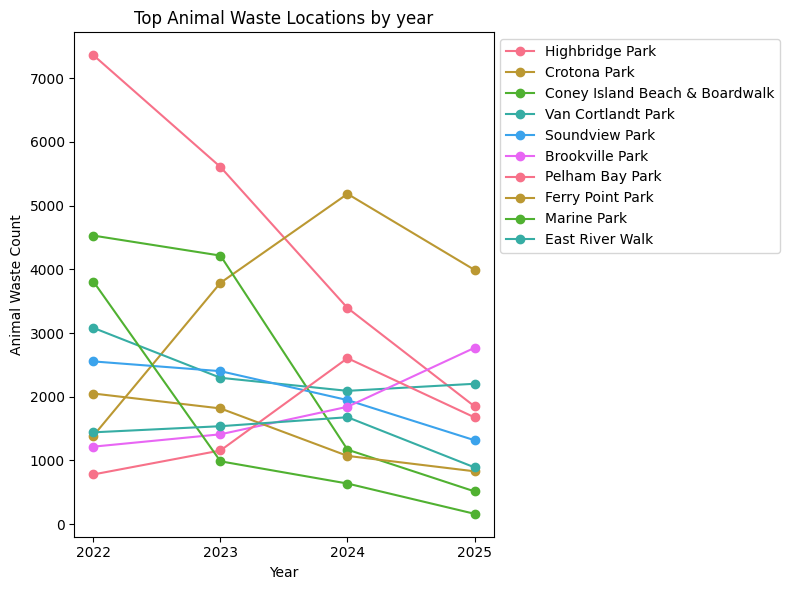

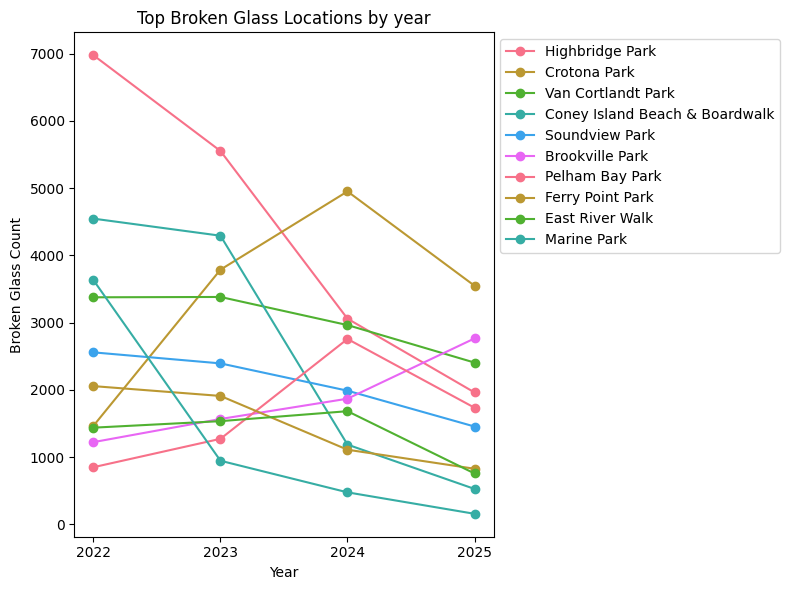

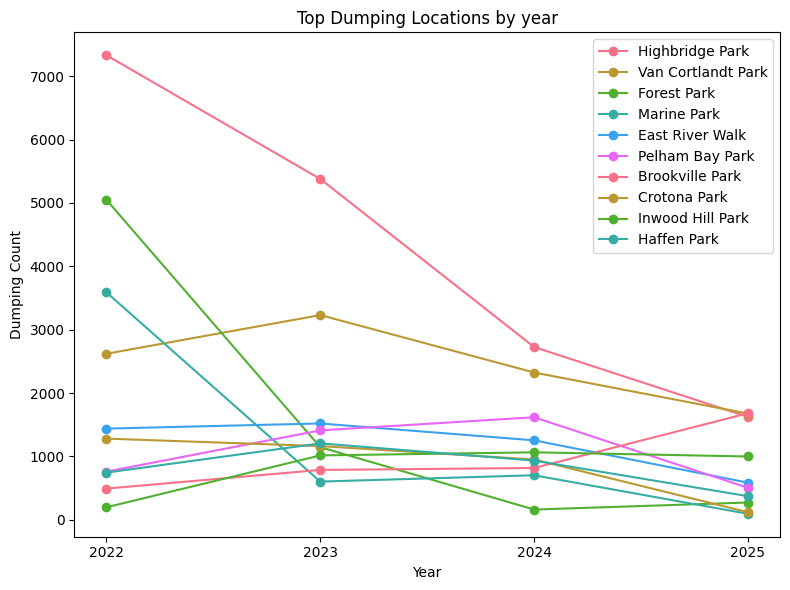

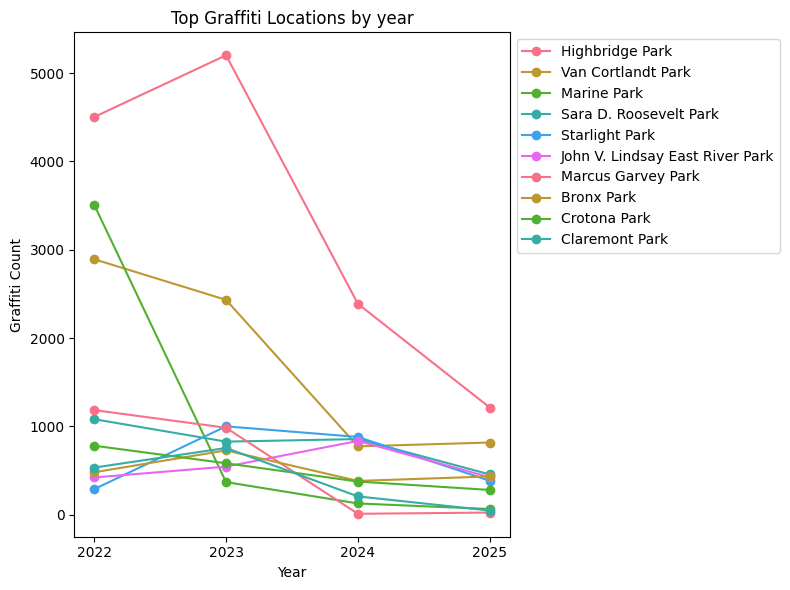

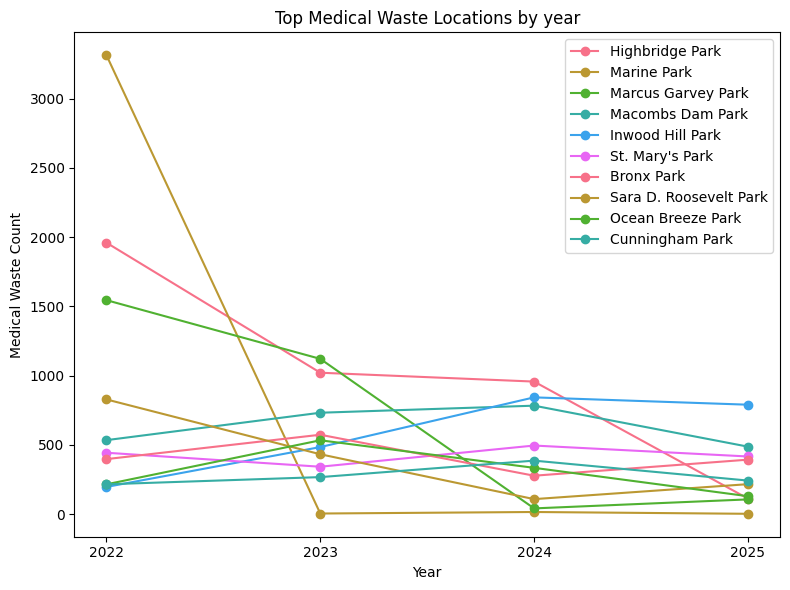

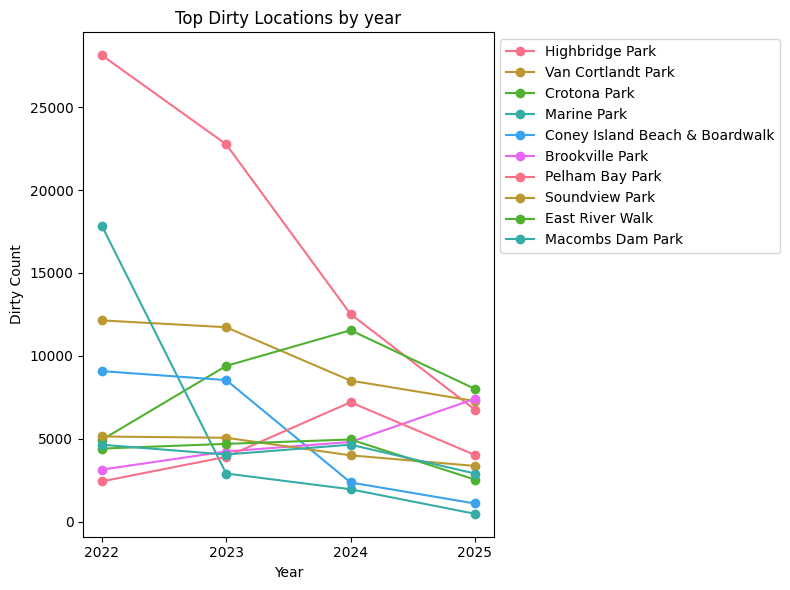

In [171]:
# Create plots for the top "gross" offenders
graph_df = df_total_c.copy().reset_index()
for col in all_binary_cols:
    plt.figure(figsize=(8, 6))

    for gispropnum in col_to_top10[col]:
        subset = graph_df[graph_df['gispropnum'] == gispropnum]
        plt.plot(subset['year'], subset[col], marker='o', label=subset["signname"].to_list()[0])

    pretty_col = col\
        .replace("_b","").replace("_sc","").replace("_"," ").title()

    plt.xlabel('Year')
    plt.ylabel(f'{pretty_col} Count')
    plt.title(f'Top {pretty_col} Locations by year')
    plt.legend(bbox_to_anchor=(1, 1), loc='best')
    plt.tight_layout()
    plt.show()

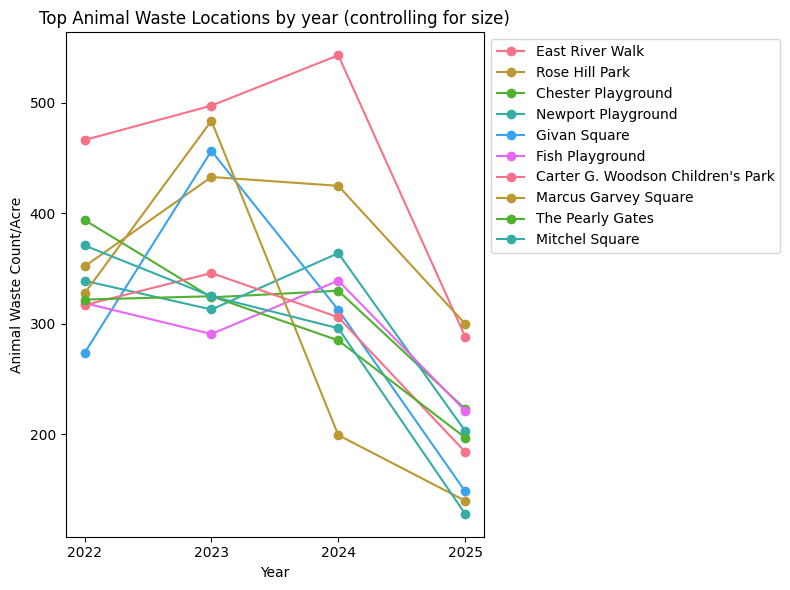

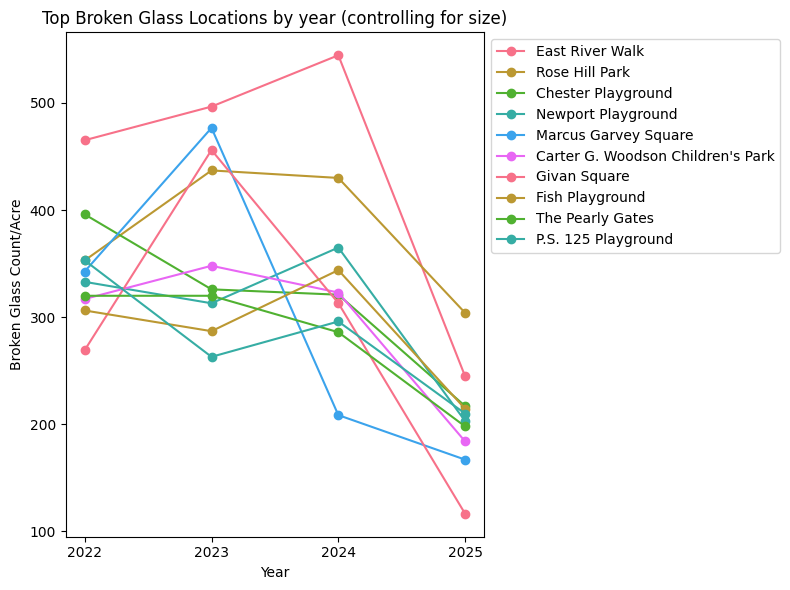

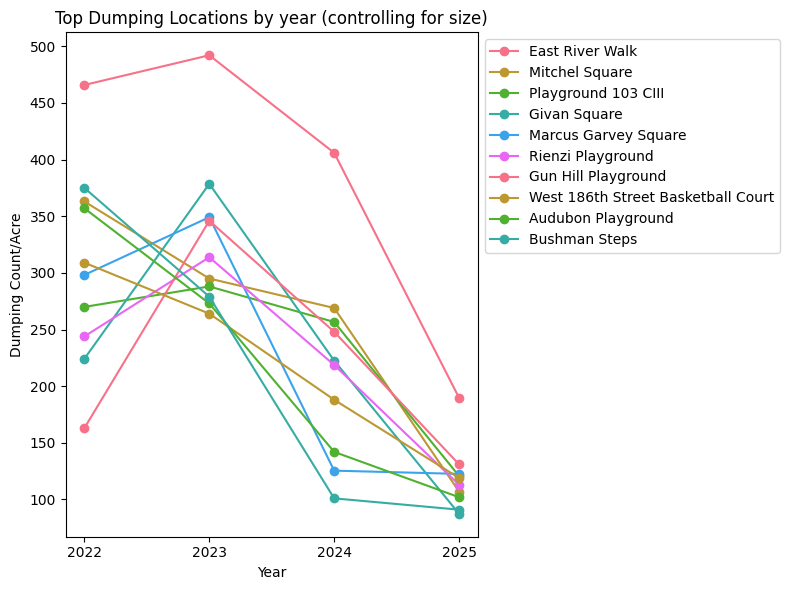

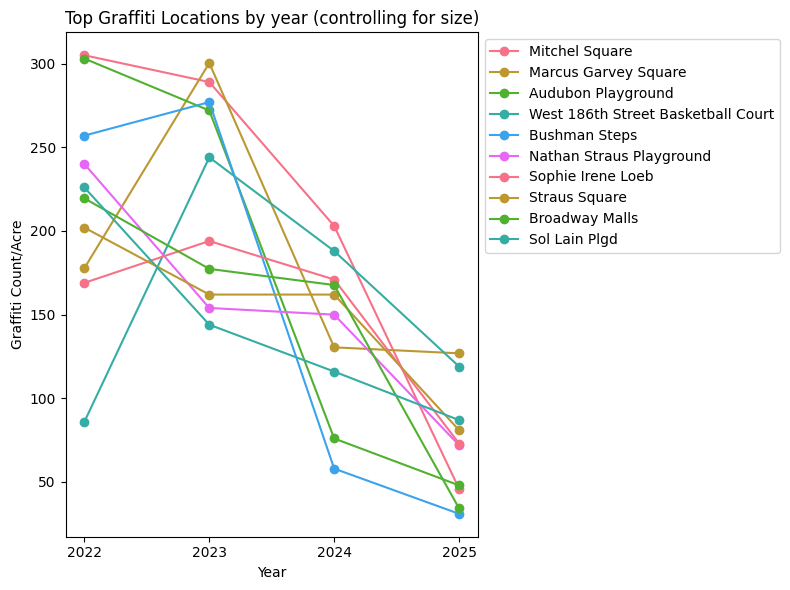

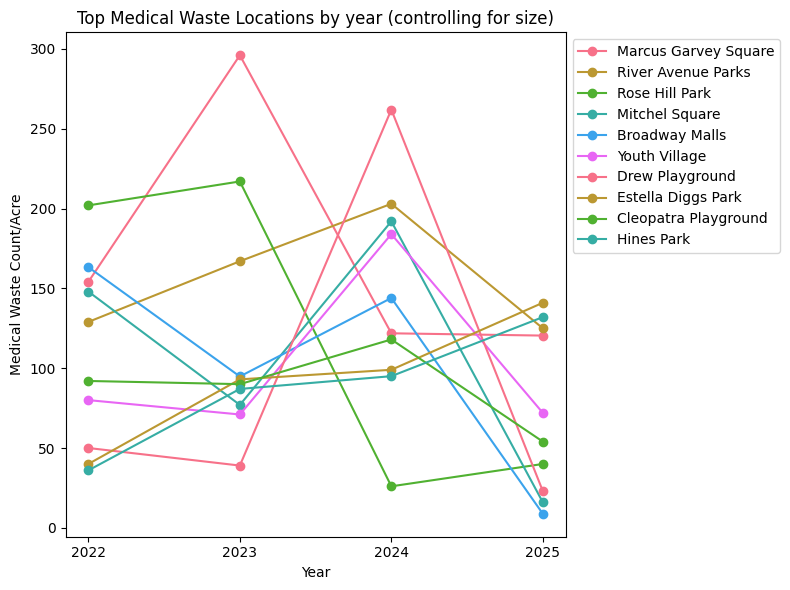

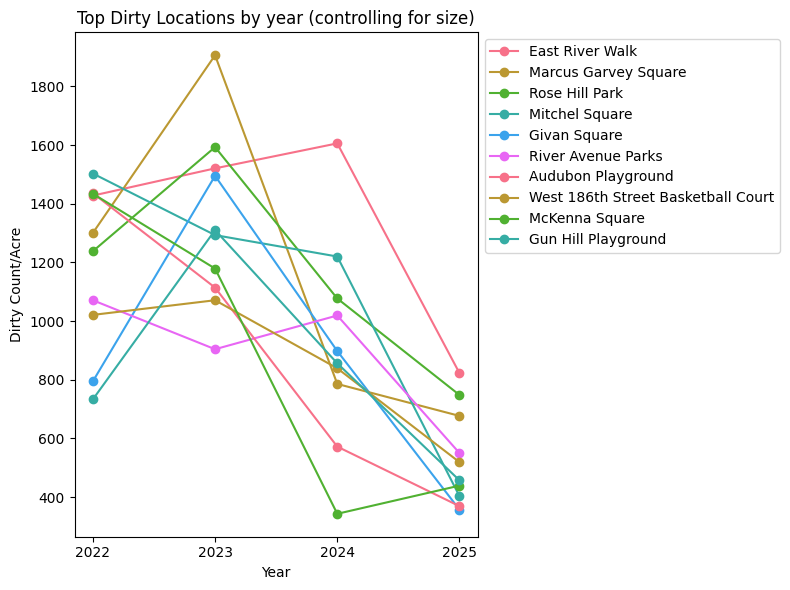

In [172]:
# Create plots for the top offenders controlling for acreage
graph_df = df_total_c.copy().reset_index()
for col in all_binary_cols_sc:
    plt.figure(figsize=(8, 6))

    for gispropnum in col_to_size_control_top10[col]:
        subset = graph_df[graph_df['gispropnum'] == gispropnum]
        plt.plot(subset['year'], subset[col], marker='o', label=subset["signname"].to_list()[0])

    pretty_col = col\
        .replace("_b","").replace("_sc","").replace("_"," ").title()

    plt.xlabel('Year')
    plt.ylabel(f'{pretty_col} Count/Acre')
    plt.title(f'Top {pretty_col} Locations by year (controlling for size)')
    plt.legend(bbox_to_anchor=(1, 1), loc='best')
    plt.tight_layout()
    plt.show()

In [167]:
overall_trends = df_total_c.copy().reset_index().groupby("year")[all_binary_cols].sum()
print("Decreases from 2022 to 2025:")
print((overall_trends.loc["2022"] - overall_trends.loc["2025"]) / overall_trends.loc["2022"])

Decreases from 2022 to 2025:
animal_waste_b     0.292509
broken_glass_b     0.310874
dumping_b          0.387465
graffiti_b         0.398815
medical_waste_b    0.501862
dirty_b            0.336692
dtype: float64


In [168]:
inspec_frames = []
for file in sorted(data_files):
    print(f"Processing {file.name}...")
    df = pd.read_csv(file)

    df_a["year"] = file.name.split(".")[0]
    inspec_frames.append(df_a)

df_inspec_total = pd.concat(a_frames)

Processing 2022.csv...
Processing 2023.csv...
Processing 2024.csv...
Processing 2025.csv...


In [170]:
print("Constant number of inspections per year")
print(df_inspec_total.groupby("year").size())

Constant number of inspections per year
year
2022    3051
2023    3060
2024    3052
2025    2978
dtype: int64
